In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of train data :", project_data.columns.values)
print('-'*50)
print("Number of data points in resource data", resource_data.shape)
print("The attributes of resource data :",resource_data.columns.values)
project_data.head(3)
#resource_data.head(3)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of train data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']
--------------------------------------------------
Number of data points in resource data (1541272, 4)
The attributes of resource data : ['id' 'description' 'quantity' 'price']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   
2                    Health & Sports    Health & Wellness, Team Sports   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0

# 1.2 Data Analysis

In [4]:
y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects that are approved for funding are", y_value_counts[1],"which is:",(y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%")
print("Number of projects that are not approved for funding are", y_value_counts[0],"which is:",(y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%")

Number of projects that are approved for funding are 92706 which is: 84.85830404217927 %
Number of projects that are not approved for funding are 16542 which is: 15.141695957820739 %


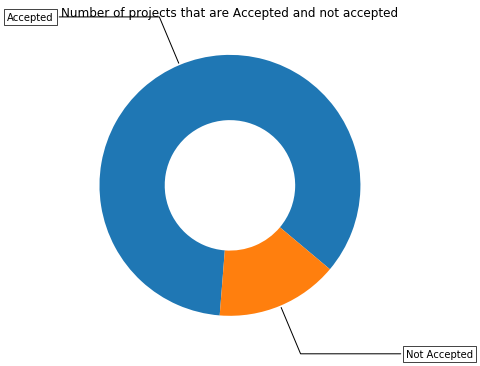

In [5]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE#pie-chart for the above calculation. It is not mandatory. Refer to the link.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html

fig,ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted","Not Accepted"]
data = [y_value_counts[1], y_value_counts[0]]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
ax.set_title("Number of projects that are Accepted and not accepted")
plt.show()

## 1.2.1 Univariate analysis-School State

In [6]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039
temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
temp.columns = ['state_code', 'num_proposals']
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


####  From the above table we can observe that state Vermont (VT) has the least proposal acceptance rate & Delaware (DE) has the max acceptance rate.

In [7]:
# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620- ignore for the moment


In [8]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    plt.figure(figsize=(20,7))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)
    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [9]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    if top:
        temp = temp[0:top]
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

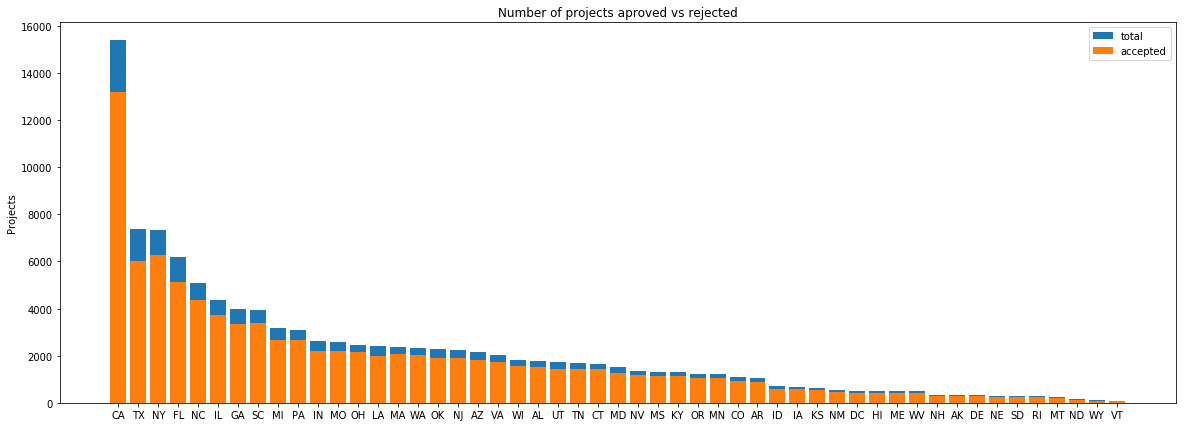

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [10]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

__SUMMARY: Every state has greater than 80% success rate in approval.__

### 1.2.2 Univariate Analysis: teacher_prefix

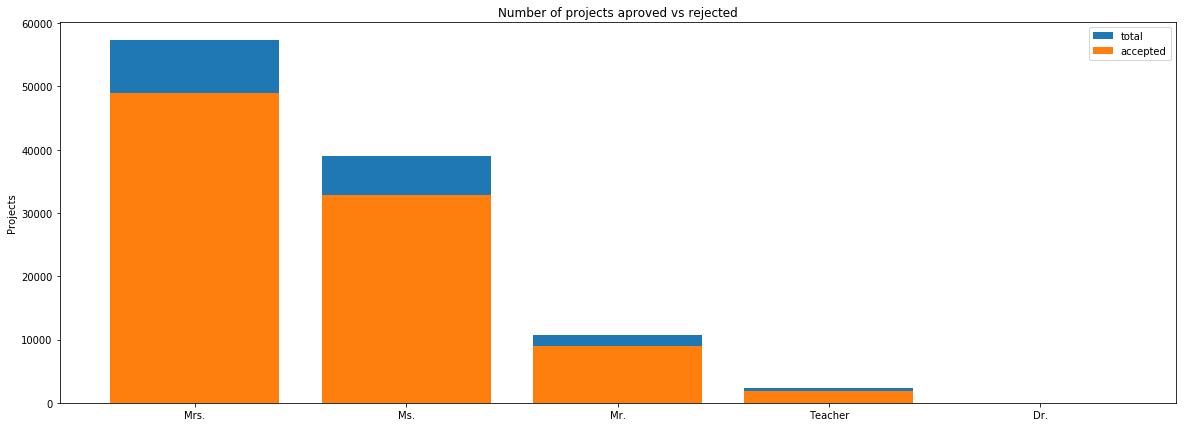

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [11]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved', False)

__SUMMARY: The accepetance rate of prjects for Dr. was found to be the least & the most for Mrs. This can change if the # of doctors pitch in with more proposals across all the states.__

### 1.2.3 Univariate Analysis: project_grade_category

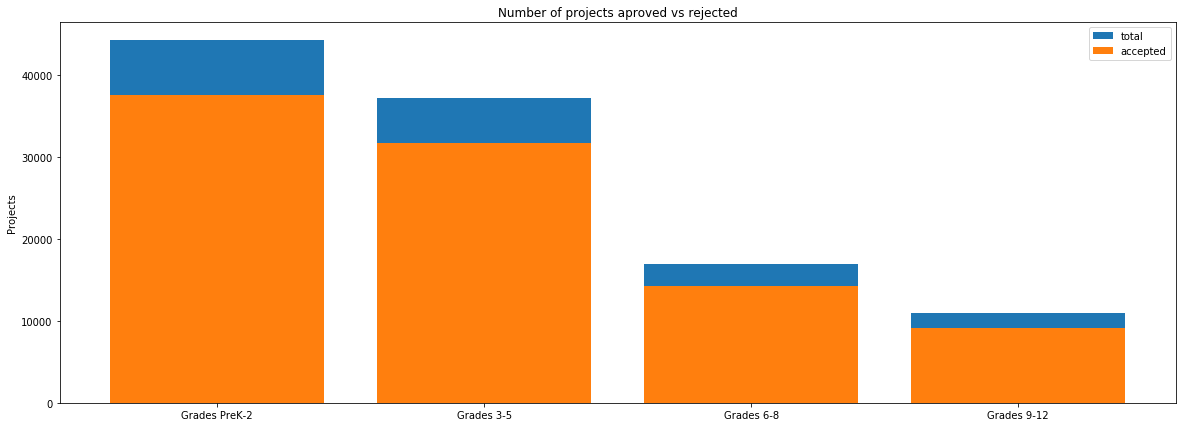

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [12]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', False)

__SUMMARY: We can observe that the acceptance rates for all the prject grade categories are close enough without much of a difference but the only take away from this part of analysis is that the total number of projects submitted for Grades PreK-2 is more compared to other grades & Grades 9-12 being the least.__

### 1.2.4 Univariate Analysis: project_subject_categories

In [13]:
categories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in categories:
    temp =""
    # consider we have text like this Math & Science, Warmth, Care & Hunger
    for j in i.split(','):   # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space Math & Science"=> "Math","&","Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','')  # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" "    #" abc ".strip() will return "abc" , remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into "_"
    cat_list.append(temp.strip())

In [14]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

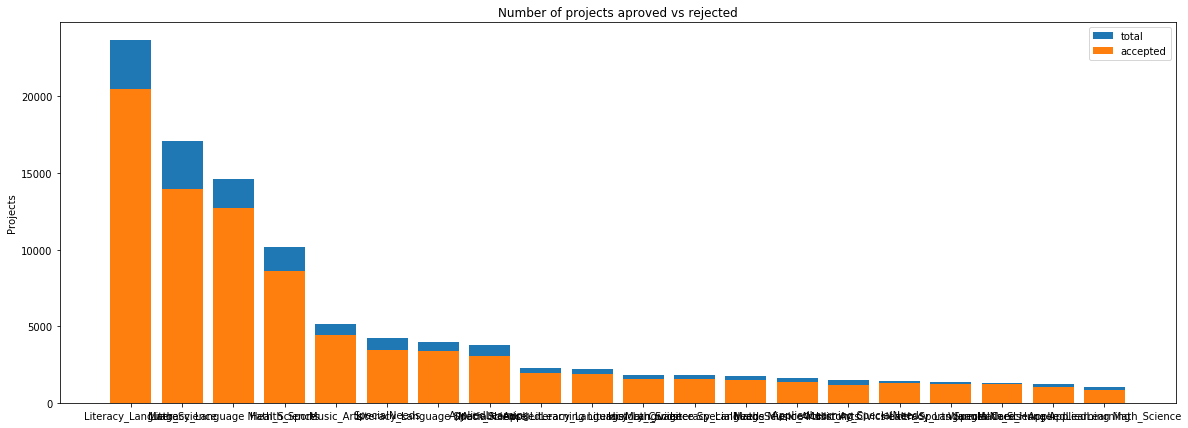

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [15]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

__SUMMARY: It is seen that projects concerning Warmth care & hunger had the highest approval rate inspite of the total # of projects submitted were less compared to others.__

In [16]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

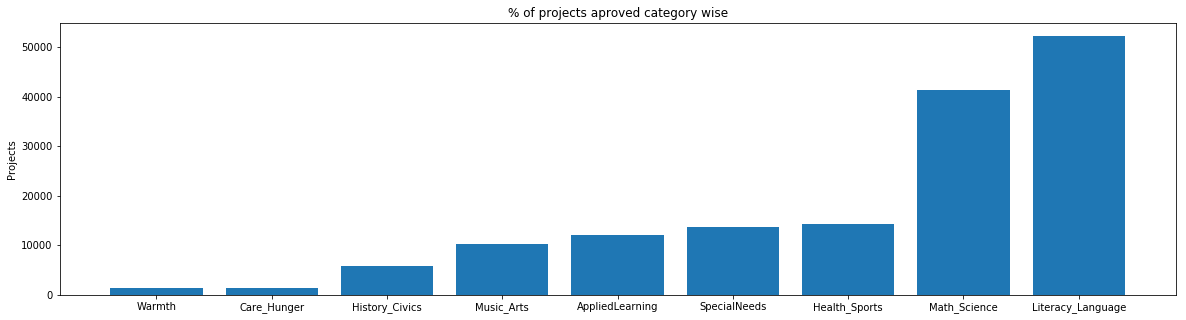

In [17]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [18]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))
    #print(i,":",j)

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


__SUMMARY: It can be observed that projects submitted in Literacy_Language(accounting for 50% of total) category was the highest & warmth,care_hunger being the lowest.__

### 1.2.5 Univariate Analysis: project_subject_subcategories

In [19]:
sub_categories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
sub_cat_list = []
for i in sub_categories:
    temp =""
    # consider we have text like this Math & Science, Warmth, Care & Hunger
    for j in i.split(','):   # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space Math & Science"=> "Math","&","Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','')  # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" "    #" abc ".strip() will return "abc" , remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into "_"
    sub_cat_list.append(temp.strip())

In [20]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

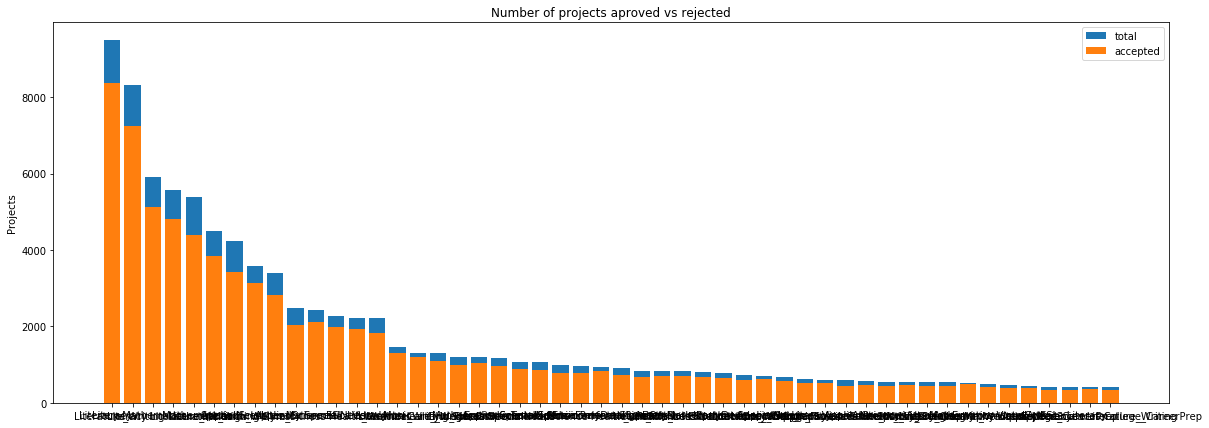

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [21]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

__SUMMARY: It can be observed that total # of projects submitted & the acceptance rate was highest for Literacy subcategory compared to other sub-categories. __

In [22]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

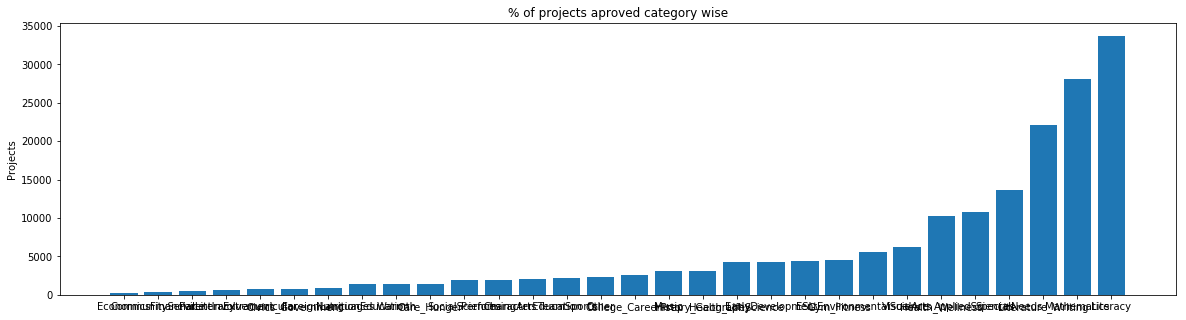

In [23]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [24]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


__SUMMARY: It can be observed that the number of projects with Literacy as sub-category was the highest & Economics was the lowest in terms of count.__

### 1.2.6 Univariate Analysis: Text features (Title)

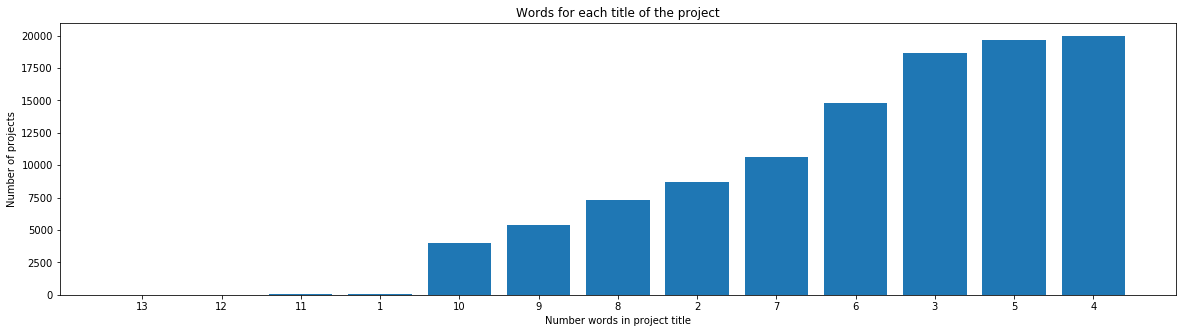

In [25]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))
plt.ylabel('Number of projects')
plt.xlabel('Number words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [26]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values
rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

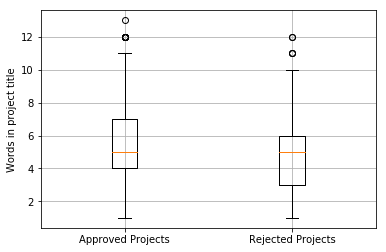

In [27]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

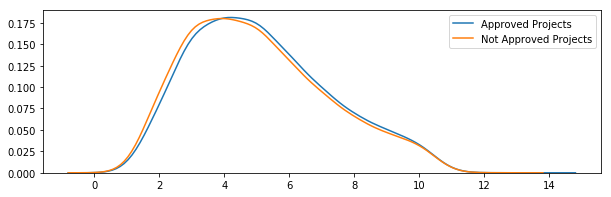

In [28]:
#pdf
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

__SUMMARY: The box plot & the pdf implies that the distribution of Approved projects > rejected projects. Hence we can say that approved projects have more words than rejected projects.__

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [29]:
# merge two column text dataframe:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html
#https://www.geeksforgeeks.org/python-pandas-map/
project_data["essay"] = project_data["project_essay_1"].map(str) + \
project_data["project_essay_2"].map(str) + \
project_data["project_essay_3"].map(str) + \
project_data["project_essay_4"].map(str)
#print(project_data["essay"][1])

In [30]:
project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   
2                 Health_Sports    Health_Wellness TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...  
2  \r\n\"True champions aren't always the ones th...

In [31]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values
rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

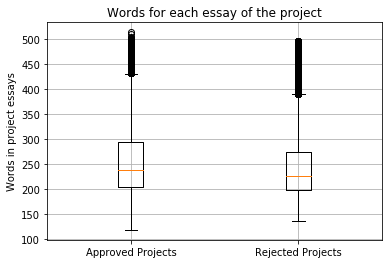

In [32]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

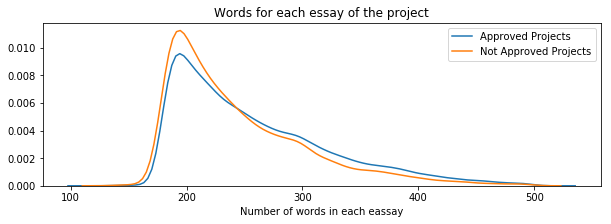

In [33]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

__SUMMARY: It can be observed from the boxplots that although the medians for approved & rejected projects are almost equal, the distribution of approved projects is larger and greater than rejected projects. Hence approved projects have more words in essays than rejected projects.__

### 1.2.8 Univariate Analysis: Cost per project

In [34]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [35]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
#https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby/19385591#19385591
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [36]:
# join two dataframes in python:
project_data = pd.merge(project_data, price_data, on='id', how='left')
approved_price = project_data[project_data['project_is_approved']==1]['price'].values
rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

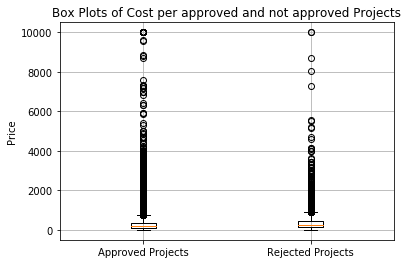

In [37]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

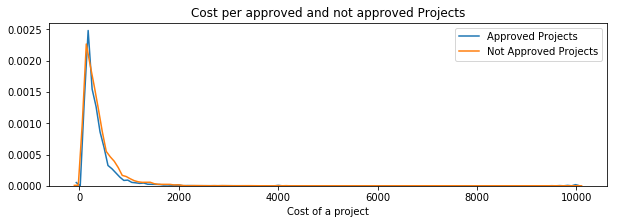

In [38]:
#pdf
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

__SUMMARY:It can be seen from the pdf that cost for rejected projects was slighlty higher than approved projects but this is not convincing, so we move ahead and use percentile as a parameter to clearly justify the cost.__

In [39]:
#percentile
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]
for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

__SUMMARY OF THE PERCENTILE TABLE:As seen from the above percentile table, the rejected project cost for every 5th percentile is greater than approved projects cost.__

### 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects

In [40]:
#previously posted projects according to teacher prefix
prefix_projects = project_data.groupby('teacher_prefix').agg({'teacher_number_of_previously_posted_projects':'sum'}).reset_index()
prefix_projects

teacher_prefix  teacher_number_of_previously_posted_projects
0            Dr.                                            53
1            Mr.                                        129559
2           Mrs.                                        639594
3            Ms.                                        441583
4        Teacher                                          7671

In [41]:
#previously posted projects according to state
state_projects = project_data.groupby('school_state').agg({'teacher_number_of_previously_posted_projects':'sum'}).reset_index()
state_projects.sort_values(by=['teacher_number_of_previously_posted_projects'],inplace=True, ascending=False)
state_projects

school_state  teacher_number_of_previously_posted_projects
4            CA                                        251179
34           NY                                        160338
27           NC                                         80616
38           PA                                         55980
9            FL                                         50089
14           IL                                         47271
43           TX                                         46933
40           SC                                         34401
22           MI                                         29884
10           GA                                         29825
15           IN                                         29416
47           WA                                         23179
24           MO                                         22261
6            CT                                         22107
35           OH                                         21664
31           NJ                                         21562
17           KY                                         18859
19           MA                                         18810
48           WI                                         18791
33           NV                                         18015
36           OK                                         16042
42           TN                                         15852
3            AZ                                         15177
45           VA                                         14191
1            AL                                         13341
18           LA                                         12207
37           OR                                         11265
2            AR                                         10997
20           MD                                         10502
23           MN                                         10303
25           MS                                          9835
44           UT                                          8781
5            CO                                          7936
13           ID                                          7790
0            AK                                          7162
8            DE                                          5984
7            DC                                          5515
32           NM                                          4899
11           HI                                          4625
49           WV                                          3811
16           KS                                          3263
12           IA                                          3053
21           ME                                          2949
39           RI                                          2307
29           NE                                          2225
30           NH                                          2141
26           MT                                          1665
41           SD                                          1347
28           ND                                          1088
46           VT                                           554
50           WY                                           474

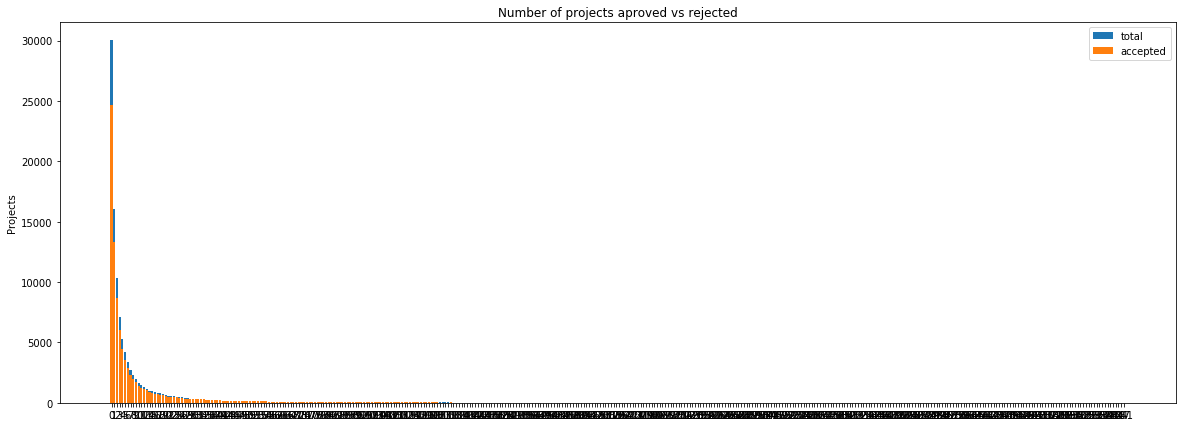

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [42]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', False)

In [43]:
approved = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects']
approved = approved.values
rejected = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects']
rejected = rejected.values

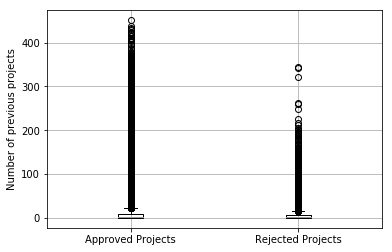

In [44]:
plt.boxplot([approved, rejected])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of previous projects')
plt.grid()
plt.show()

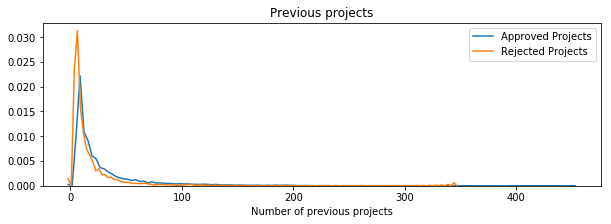

In [45]:
#pdf
plt.figure(figsize=(10,3))
sns.distplot(approved, hist=False, label="Approved Projects")
sns.distplot(rejected, hist=False, label="Rejected Projects")
plt.title('Previous projects')
plt.xlabel('Number of previous projects')
plt.legend()
plt.show()

### SUMMARY:
1. It can be observed that across USA a maximum of 639.5K projects were posted alone by Mrs. & 53 being the least number posted    by Dr's.
2. It is observed that projects posting by teachers were highest in CA(California) with a staggering number of 251K & least        being 474 in WA(Washington)
3. Finally, it can be observed that more the number of projects submitted previously, the higher is the chance of that project      being approved by the committee. Hence experience of teachers in project submission plays a vital role in the acceptance of      the project.

### 1.2.10 Univariate Analysis: project_resource_summary

In [46]:
#https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def check(data):
    return any(char.isdigit() for char in data)

resource_summary=project_data['project_resource_summary']
values=resource_summary.map(check)
project_data['Numerical digits in summary']=values
#https://stackoverflow.com/questions/39698672/pandas-replace-boolean-value-with-string-or-integer
project_data['Numerical digits in summary'] = np.where(project_data['Numerical digits in summary'], 1, 0)
project_data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   
2  The students on the campus come to school know...   
3  My students live in high poverty conditions wi...   
4  For many students, math is a subject that does...   

              ...              project_essay_4  \
0             ...                          NaN   
1             ...                          NaN   
2             ...                          NaN   
3             ...                          NaN   
4             ...                          NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   
3  My students need to engage in Reading and Math...   
4  My students need hands on practice in mathemat...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   
2                                            1                    0   
3                                            4                    1   
4                                            1                    1   

                 clean_categories           clean_subcategories  \
0               Literacy_Language                  ESL Literacy   
1    History_Civics Health_Sports  Civics_Government TeamSports   
2                   Health_Sports    Health_Wellness TeamSports   
3  Literacy_Language Math_Science          Literacy Mathematics   
4                    Math_Science                   Mathematics   

                                               essay   price  quantity  \
0  My students are English learners that are work...  154.60        23   
1  Our students arrive to our school eager to lea...  299.00         1   
2  \r\n\"True champions aren't always the ones th...  516.85        22   
3  I work at a unique school filled with both ESL...  232.90         4   
4  Our second grade classroom next year will be m...   67.98         4   

   Numerical digits in summary  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 21 columns

In [47]:
#Numbers used by teachers according to teacher prefix in order to quantify claim in the summary
prefix_summary_count = project_data.groupby('Numerical digits in summary').agg({'teacher_prefix':'count'}).reset_index()
prefix_summary_count

Numerical digits in summary  teacher_prefix
0                            0           93490
1                            1           15755

In [48]:
project_data_1=project_data[project_data['Numerical digits in summary']==1]
prefix_summary_individuals = project_data_1.groupby('teacher_prefix').agg({'Numerical digits in summary':'count'}).reset_index()
prefix_summary_individuals

teacher_prefix  Numerical digits in summary
0            Dr.                            1
1            Mr.                         1933
2           Mrs.                         8284
3            Ms.                         5204
4        Teacher                          333

__SUMMARY: As seen from the summary tables above, there were just around 15.7K out of 100K teachers who used numerics in the summary and there were many projects(i.e.8284) submitted by teachers with prefix Mrs. who used numerics quite often than others.__

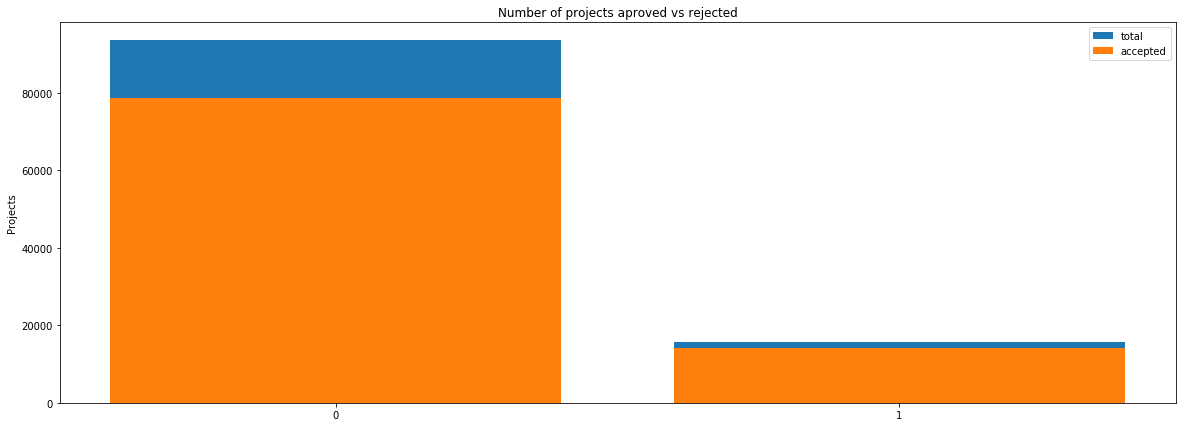

   Numerical digits in summary  project_is_approved  total       Avg
0                            0                78616  93492  0.840885
1                            1                14090  15756  0.894263
   Numerical digits in summary  project_is_approved  total       Avg
0                            0                78616  93492  0.840885
1                            1                14090  15756  0.894263


In [49]:
univariate_barplots(project_data, 'Numerical digits in summary', 'project_is_approved', False)

### SUMMARY:
1. It can be observed that the acceptance rate for projects having numbers in the summary were marginally higher than the ones      without any numbers in the summary.
2. I would conclude that this parameter/ feature of Numerical digits in summary has less impact on the project acceptance as there is a marginal difference in acceptance with or without numbers in the summary.

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [50]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   

              ...              project_essay_4  \
0             ...                          NaN   
1             ...                          NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   Numerical digits in summary  
0                            0  
1                            0  

[2 rows x 21 columns]

In [51]:
# printing some random essays
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids don't want to sit and do worksheets. They want to learn to count by jumping and playing.

In [52]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):# specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [53]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [54]:
# \\r \\n \\t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.   n  nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. P

In [55]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations n nThe materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills nThey also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is

In [57]:
# Combining all the above statemennts
from tqdm import tqdm # tqdm is for printing the status bar
preprocessed_essays = []
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords.words('english'))
    #sent = [snow.stem(word) for word in sent.split() if word not in stopwords.words('english')]
    #temp.append(words)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [39:00:10<00:00,  9.61it/s]


In [59]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

### 1.3.2 Project title Text

In [56]:
# printing some random titles
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[99999])
print("="*50)

We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [57]:
#decontraction
import re
def decontracted(phrase):# specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
sent = decontracted(project_data['project_title'].values[20000])
print(sent)
print("="*50)

We Need To Move It While We Input It!


In [59]:
# \\r \\n \\t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

We Need To Move It While We Input It!


In [60]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

We Need To Move It While We Input It 


In [61]:
# Combining all the above statemennts
from tqdm import tqdm # tqdm is for printing the status bar
preprocessed_titles = []
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords.words('english'))
    #sent = [snow.stem(word) for word in sent.split() if word not in stopwords.words('english')]
    #temp.append(words)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [04:30<00:00, 403.78it/s]


In [62]:
# after preprocesing
preprocessed_titles[20000]

'we need to move it while we input it'

In [63]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   

              ...              project_essay_4  \
0             ...                          NaN   
1             ...                          NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   Numerical digits in summary  
0                            0  
1                            0  

[2 rows x 21 columns]

In [64]:
project_data['preprocessed_titles']=preprocessed_titles
project_data.head(2)
title_column=project_data[['id','preprocessed_titles']]
#title_column.shape
title_column.head(2)

id                        preprocessed_titles
0  p253737  educational support english learners home
1  p258326           wanted projector hungry learners

## 1. 4 Preparing data for models

#### Features in our project_data can be roughly classified into 3 categories:
1. Categorical data like school_state,clean_categories,clean_subcategories,project_grade_category,teacher_prefix. Convert to        one-hot encoding variations
2. Text data like project_title, essay, project_resource_summary- Apply featurization techniques like BOW,TFIDF,W2V etc
3. Numerical data like quantity,teacher_number_of_previously_posted_projects,price- Apply standardization

### 1.4.1 Vectorizing Categorical data

https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features

In [65]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'Numerical digits in summary', 'preprocessed_titles'],
      dtype='object')

In [66]:
# we use count vectorizer to convert the values into one hot encoded features
#one-hot encoding for clean_categories
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())
categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig (109248, 9)


In [67]:
#one-hot encoding for clean_sub_categories
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())
sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig (109248, 30)


In [68]:
#one-hot encoding for school_state
#https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
ss_values = list(project_data['school_state'].values)
vectorizer = CountVectorizer()
vectorizer.fit(ss_values)
print(vectorizer.get_feature_names())
school_state_one_hot = vectorizer.transform(ss_values)
print("Shape of matrix after one hot encodig",school_state_one_hot.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encodig (109248, 51)


In [69]:
#one-hot encoding for project_grade_category
project_grade_category = list(project_data['project_grade_category'].values)
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=4)
vectorizer.fit(project_grade_category)
print(vectorizer.get_feature_names())
project_grade_category_one_hot = vectorizer.transform(project_grade_category)
print("Shape of matrix after one hot encoding",project_grade_category_one_hot.shape)

['12', 'grades', 'grades prek', 'prek']
Shape of matrix after one hot encoding (109248, 4)


In [70]:
#checking for NaN values in the column
teacher_prefix = list(project_data['teacher_prefix'].values)
teacher_prefix
print("Number of Nan values in teacher_prefix column:",project_data['teacher_prefix'].isnull().values.sum())

Number of Nan values in teacher_prefix column: 3


In [71]:
#one-hot encoding for teacher_prefix
#https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
project_data['teacher_prefix'].fillna('none',inplace = True) #NaN values have been replaced with none
teacher_prefix = list(project_data['teacher_prefix'].values)
vectorizer = CountVectorizer()
vectorizer.fit(teacher_prefix)
print(vectorizer.get_feature_names())
teacher_prefix_one_hot = vectorizer.transform(teacher_prefix)
print("Shape of matrix after one hot encodig",teacher_prefix_one_hot.shape)

['dr', 'mr', 'mrs', 'ms', 'none', 'teacher']
Shape of matrix after one hot encodig (109248, 6)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

#We are considering only the words which appeared in at least 10 documents(rows or projects).
#BOW for preprocessed_essays
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after applying BOW",text_bow.shape)

In [72]:
#BOW for preprocessed_titles
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after applying BOW",title_bow.shape)

Shape of matrix after applying BOW (109248, 3329)


In [73]:
# https://stackoverflow.com/questions/35874744/python-how-to-check-if-matrix-is-sparse-or-not
from scipy import sparse
sparse.issparse(title_bow)

True

#### 1.4.2.3 TFIDF vectorizer

In [77]:
#TFIDF for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
essay_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after applying TFIDF",essay_tfidf.shape)

Shape of matrix after applying TFIDF (109248, 16623)


In [73]:
#TFIDF for preprocessed_titless
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after applying TFIDF",title_tfidf.shape)

Shape of matrix after applying TFIDF (109248, 3329)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

#loading glove vectors contaning W2V for all the documents in the corpus
#Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
        print ("Done.",len(model)," words loaded!")
        return model
model = loadGloveModel('glove_vectors')

In [74]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
print ("Done.",len(model)," words loaded!")

Done. 51510  words loaded!


In [80]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []   # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays):   # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sentence.split():  # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)
print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:52<00:00, 2093.27it/s]


109248
300


### 1.4.2.6 Using Pretrained Models: AVG W2V on project_title

In [75]:
avg_w2v_vectors_title = []   
for sentence in tqdm(preprocessed_titles):  
    vector = np.zeros(300) 
    cnt_words =0 
    for word in sentence.split():  
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title.append(vector)
print(len(avg_w2v_vectors_title))
print(len(avg_w2v_vectors_title[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 44417.33it/s]


109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

#S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays) 
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

### 1.4.2.8 Using Pretrained Models: TFIDF weighted W2V on preprocessed_essays

In [86]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [06:04<00:00, 299.93it/s]


109248
300


### 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on project_title

tfidf_w2v_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

### 1.4.3 Vectorizing Numerical features

In [77]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ]
# Reshape your data either using array.reshape(-1, 1)
#numerical features for price
price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1))
# finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [78]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

In [79]:
#numerical features for quantity
import warnings
warnings.filterwarnings("ignore")
quantity_scalar = StandardScaler()
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1))
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")
quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964, Standard deviation : 26.182821919093175


In [80]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

In [81]:
#numerical features for teacher_number_of_previously_posted_projects
previousprojects_scalar = StandardScaler()
previousprojects_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {previousprojects_scalar.mean_[0]}, Standard deviation : {np.sqrt(previousprojects_scalar.var_[0])}")
previousprojects_standardized = previousprojects_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848, Standard deviation : 27.77702641477403


In [82]:
previousprojects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

In [86]:
from scipy import sparse
sparse.issparse(previousprojects_standardized)

False

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

In [118]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape
#X.dtype

(109248, 16663)

# <font color='red'>Assignment 2: Apply TSNE<font>

1. In the above cells we have plotted and analyzed many features. Please observe the plots and write the observations in markdown cells below every plot.
2. EDA: Please complete the analysis of the feature: teacher_number_of_previously_posted_projects
3. Build the data matrix using these features
   - school_state : categorical data (one hot encoding)
   - clean_categories : categorical data (one hot encoding)
   - clean_subcategories : categorical data (one hot encoding)
   - teacher_prefix : categorical data (one hot encoding)
   - project_grade_category : categorical data (one hot encoding)
   - project_title : text data (BOW, TFIDF, AVG W2V, TFIDF W2V)
   - price : numerical
   - teacher_number_of_previously_posted_projects : numerical
4. Now, plot FOUR t-SNE plots with each of these feature sets.
   - A.categorical, numerical features + project_title(BOW)
   - B.categorical, numerical features + project_title(TFIDF)
   - C.categorical, numerical features + project_title(AVG W2V)
   - D.categorical, numerical features + project_title(TFIDF W2V)
5. Concatenate all the features and Apply TNSE on the final data matrix
6. <font color='blue'>Note 1: The TSNE accepts only dense matrices</font>
7. <font color='blue'>Note 2: Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-points you are using</font></li>

## I'm considering 5K data points for this analysis.

### 2.1 Data preparation

#### Selecting 5000 data points (with equal approval & rejected datapoints i.e. 2.5K)  from project_data for t-NSE analysis purpose.

In [83]:
approved=project_data[project_data['project_is_approved']==1]
rejected=project_data[project_data['project_is_approved']==0]
approved.head(5)
approved_top=approved[0:2500]
approved_top.head(5)
rejected_top=rejected[0:2500]
rejected_top.head(10)
data_5K=pd.concat([approved_top,rejected_top], axis=0,ignore_index=True)
data_5K.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
1          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           FL        2016-10-25 09:22:10             Grades 6-8   
1           KY        2016-10-06 21:16:17          Grades PreK-2   

                           project_title  \
0  Wanted: Projector for Hungry Learners   
1                 Techie Kindergarteners   

                                     project_essay_1  \
0  Our students arrive to our school eager to lea...   
1  I work at a unique school filled with both ESL...   

                                     project_essay_2  \
0  The projector we need for our school is very c...   
1  My students live in high poverty conditions wi...   

                 ...                 \
0                ...                  
1                ...                  

                            project_resource_summary  \
0  My students need a projector to help with view...   
1  My students need to engage in Reading and Math...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                            7                   1   
1                                            4                   1   

                 clean_categories           clean_subcategories  \
0    History_Civics Health_Sports  Civics_Government TeamSports   
1  Literacy_Language Math_Science          Literacy Mathematics   

                                               essay  price quantity  \
0  Our students arrive to our school eager to lea...  299.0        1   
1  I work at a unique school filled with both ESL...  232.9        4   

   Numerical digits in summary               preprocessed_titles  
0                            0  wanted projector hungry learners  
1                            0            techie kindergarteners  

[2 rows x 22 columns]

In [84]:
#counts of approved & rejected projects in the 5K data set.
data_5K['project_is_approved'].value_counts()

1    2500
0    2500
Name: project_is_approved, dtype: int64

### 2.2 Preparing Data Matrices for Categorical,numerical & text features for 5K points

#### Categorical Features:

In [85]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in data_5K['clean_categories'].values:
    my_counter.update(word.split())

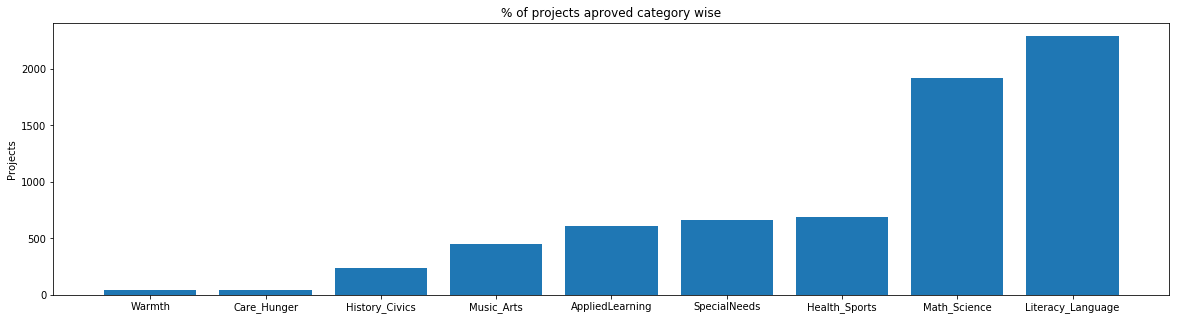

In [86]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [87]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :        45
Care_Hunger          :        45
History_Civics       :       241
Music_Arts           :       455
AppliedLearning      :       614
SpecialNeeds         :       662
Health_Sports        :       688
Math_Science         :      1918
Literacy_Language    :      2292


__SUMMARY: It can be observed that projects submitted in Literacy_Language(accounting for 50% of total) category was the highest & warmth,care_hunger being the lowest.__

In [88]:
# we use count vectorizer to convert the values into one hot encoded features
#one-hot encoding for clean_categories
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(data_5K['clean_categories'].values)
print(vectorizer.get_feature_names())
categories_one_hot = vectorizer.transform(data_5K['clean_categories'].values)
print("Shape of matrix after one hot encoding",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encoding (5000, 9)


In [89]:
from collections import Counter
my_counter = Counter()
for word in data_5K['clean_subcategories'].values:
    my_counter.update(word.split())

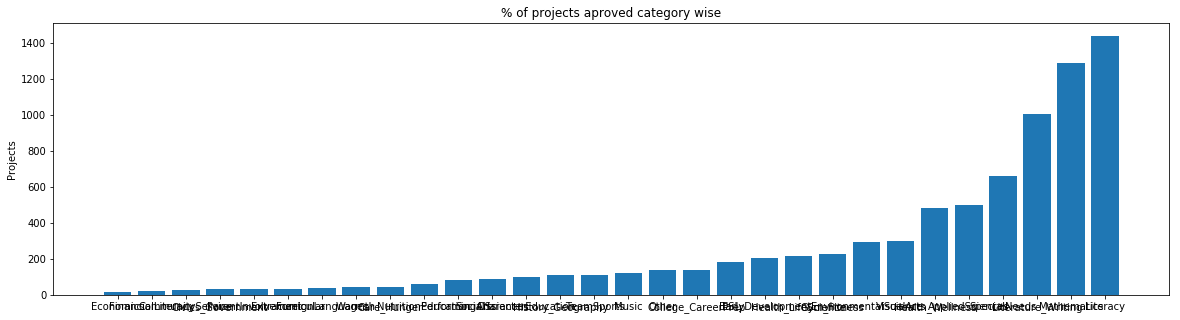

In [90]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))
plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [91]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :        14
FinancialLiteracy    :        24
CommunityService     :        29
Civics_Government    :        32
ParentInvolvement    :        33
Extracurricular      :        35
ForeignLanguages     :        36
Warmth               :        45
Care_Hunger          :        45
NutritionEducation   :        63
PerformingArts       :        82
SocialSciences       :        88
CharacterEducation   :       102
History_Geography    :       110
TeamSports           :       112
Music                :       122
Other                :       136
College_CareerPrep   :       136
ESL                  :       182
EarlyDevelopment     :       205
Health_LifeScience   :       215
Gym_Fitness          :       226
EnvironmentalScience :       294
VisualArts           :       297
Health_Wellness      :       483
AppliedSciences      :       501
SpecialNeeds         :       662
Literature_Writing   :      1006
Mathematics          :      1289
Literacy             :      1436


In [92]:
#one-hot encoding for clean_sub_categories
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(data_5K['clean_subcategories'].values)
print(vectorizer.get_feature_names())
sub_categories_one_hot = vectorizer.transform(data_5K['clean_subcategories'].values)
print("Shape of matrix after one hot encodig",sub_categories_one_hot.shape)

['Economics', 'FinancialLiteracy', 'CommunityService', 'Civics_Government', 'ParentInvolvement', 'Extracurricular', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'PerformingArts', 'SocialSciences', 'CharacterEducation', 'History_Geography', 'TeamSports', 'Music', 'Other', 'College_CareerPrep', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig (5000, 30)


In [93]:
#one-hot encoding for school_state
#https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
ss_values = list(data_5K['school_state'].values)
vectorizer = CountVectorizer()
vectorizer.fit(ss_values)
print(vectorizer.get_feature_names())
school_state_one_hot = vectorizer.transform(ss_values)
print("Shape of matrix after one hot encoding",school_state_one_hot.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encoding (5000, 51)


In [94]:
#one-hot encoding for project_grade_category
project_grade_category = list(data_5K['project_grade_category'].values)
vectorizer = CountVectorizer(ngram_range=(1,2),max_features=4)
vectorizer.fit(project_grade_category)
print(vectorizer.get_feature_names())
project_grade_category_one_hot = vectorizer.transform(project_grade_category)
print("Shape of matrix after one hot encodig",project_grade_category_one_hot.shape)

['12', 'grades', 'grades prek', 'prek']
Shape of matrix after one hot encodig (5000, 4)


In [95]:
#checking for NaN values in the column
#https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
teacher_prefix = list(data_5K['teacher_prefix'].values)
teacher_prefix
print("Number of Nan values in teacher_prefix column:",data_5K['teacher_prefix'].isnull().values.sum())

Number of Nan values in teacher_prefix column: 0


In [98]:
data_5K['teacher_prefix'].unique()

array(['Mr.', 'Mrs.', 'Ms.', 'Teacher'], dtype=object)

In [99]:
#one-hot encoding for teacher_prefix
#https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
#project_data['teacher_prefix'].fillna('none',inplace = True) #NaN values have been replaced with none
teacher_prefix = list(data_5K['teacher_prefix'].values)
vectorizer = CountVectorizer()
vectorizer.fit(teacher_prefix)
print(vectorizer.get_feature_names())
teacher_prefix_one_hot = vectorizer.transform(teacher_prefix)
print("Shape of matrix after one hot encodig",teacher_prefix_one_hot.shape)

['mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encodig (5000, 4)


#### Text Features: BOW, TFIDF, AVG W2V, TFIDF W2V on Project_title

#### 1. BOW

In [100]:
#BOW for preprocessed_titles
vectorizer = CountVectorizer(min_df=10)
title_bow = vectorizer.fit_transform(data_5K['preprocessed_titles'])
print("Shape of matrix after applying BOW",title_bow.shape)

Shape of matrix after applying BOW (5000, 369)


In [101]:
# https://stackoverflow.com/questions/35874744/python-how-to-check-if-matrix-is-sparse-or-not
from scipy import sparse
sparse.issparse(title_bow)

True

#### 2. TFIDF vectorizer

In [102]:
#TFIDF for preprocessed_titles
vectorizer = TfidfVectorizer(min_df=10)
title_tfidf = vectorizer.fit_transform(data_5K['preprocessed_titles'])
print("Shape of matrix after applying TFIDF",title_tfidf.shape)

Shape of matrix after applying TFIDF (5000, 369)


#### 3. AVG W2V on project_title

In [103]:
#Train your own Word2Vec model using your own text corpus
w2v_data = data_5K['preprocessed_titles']
split=[]
for row in w2v_data: 
    split.append([word for word in row.split()])     #splitting words
#split[100]
#train your W2v
train_w2v = Word2Vec(split,min_count=1,size=50, workers=4)
word_vectors = train_w2v.wv
w2v_words =list(word_vectors.vocab)
print(len(w2v_words ))

3933


In [104]:
# compute average word2vec for each title.
sent_vectors = [] # the avg-w2v for each title is stored in this list
for sent in tqdm(split):   # for each title
    sent_vec = np.zeros(50)  # as word vectors are of zero length 50
    cnt_words =0   # num of words with a valid vector in the title
    for word in sent:   # for each word in a title
        if word in w2v_words:
            vec = word_vectors[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[3]))
from scipy.sparse import coo_matrix
a=coo_matrix(sent_vectors) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html
a.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7804.76it/s]


5000
50


(5000, 50)

#### 4. TFIDF weighted W2V on project_title

In [105]:
model = TfidfVectorizer()
model.fit(data_5K['preprocessed_titles'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names()
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(split): # for each review/sentence
    sent_vec = np.zeros(50)  # as word vectors are of zero length
    weight_sum =0  # num of words with a valid vector in the sentence/review\
    for word in sent:  # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = word_vectors[word] 
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are using dictionary[word] = idf value of word in whole courpus
            # & sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[2]))
b=coo_matrix(tfidf_sent_vectors) #https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html
b.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2659.68it/s]


5000
50


(5000, 50)

#### Numerical Features: Standardization on Price & teacher_number_of_previously_posted_projects

In [106]:
from sklearn.preprocessing import StandardScaler
price_scalar = StandardScaler()
price_scalar.fit(data_5K['price'].values.reshape(-1,1))
# finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# Now standardize the data with above mean and variance.
price_standardized = price_scalar.transform(data_5K['price'].values.reshape(-1, 1))

Mean : 325.74432800000005, Standard deviation : 384.0878237218519


In [107]:
#numerical features for teacher_number_of_previously_posted_projects
import warnings
warnings.filterwarnings("ignore")
previousprojects_scalar = StandardScaler()
previousprojects_scalar.fit(data_5K['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {previousprojects_scalar.mean_[0]}, Standard deviation : {np.sqrt(previousprojects_scalar.var_[0])}")
previousprojects_standardized = previousprojects_scalar.transform(data_5K['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 9.2148, Standard deviation : 23.00654387255939


### 3.1 TSNE with BOW encoding of project_title feature

#### 3.1.1 Merging features i.e  all catogorical, numerical & BOW vectors.

In [108]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(project_grade_category_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(title_bow.shape)
print(price_standardized.shape)
print(previousprojects_standardized.shape)

(5000, 9)
(5000, 30)
(5000, 51)
(5000, 4)
(5000, 4)
(5000, 369)
(5000, 1)
(5000, 1)


In [109]:
from scipy.sparse import hstack
X1 = hstack((categories_one_hot, sub_categories_one_hot,school_state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot, title_bow,price_standardized,previousprojects_standardized))
X1.shape

(5000, 469)

#### 3.1.2 T-SNE plots for various values of perplexity & iterations .

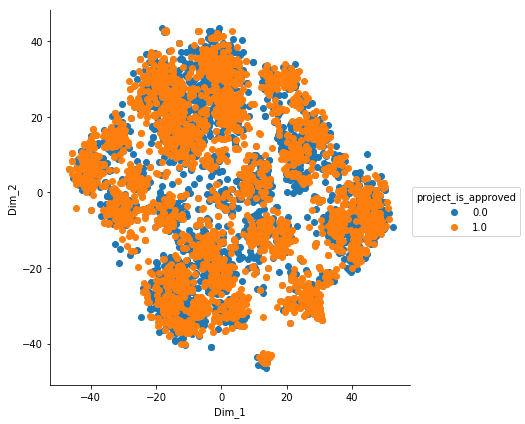

In [112]:
#t-SNE
#perplexity=50 & step=1000
from sklearn.manifold import TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data = model.fit_transform(X1.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

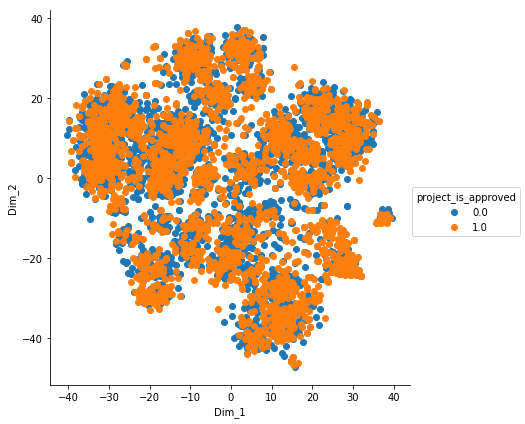

In [292]:
#perplexity=70 & step=1500
from sklearn.manifold import TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=1500)
tsne_data = model.fit_transform(X1.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

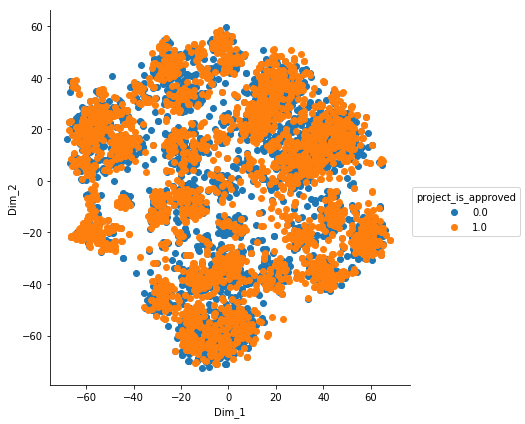

In [293]:
#perplexity=30 & step=2000
from sklearn.manifold import TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000)
tsne_data = model.fit_transform(X1.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

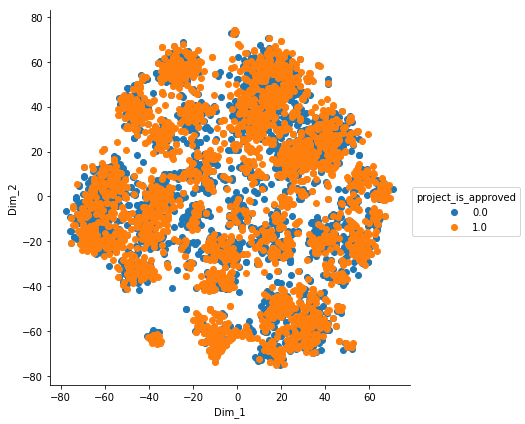

In [113]:
#perplexity=20 & step=1500
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1500)
tsne_data = model.fit_transform(X1.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 3.2 TSNE with TFIDF encoding of project_title feature

#### 3.2.1 Merging features i.e  all catogorical, numerical & TFIDF vectors.

In [110]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(project_grade_category_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(title_tfidf.shape)
print(price_standardized.shape)
print(previousprojects_standardized.shape)

(5000, 9)
(5000, 30)
(5000, 51)
(5000, 4)
(5000, 4)
(5000, 369)
(5000, 1)
(5000, 1)


In [111]:
from scipy.sparse import hstack
X2 = hstack((categories_one_hot, sub_categories_one_hot,school_state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot, title_tfidf,price_standardized,previousprojects_standardized))
X2.shape

(5000, 469)

#### 3.2.2 T-SNE plots for various values of perplexity & iterations .

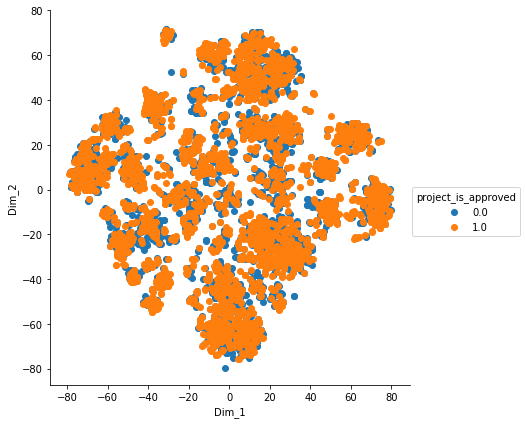

In [116]:
#t-SNE
#perplexity=30 & step=1000
from sklearn.manifold import TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

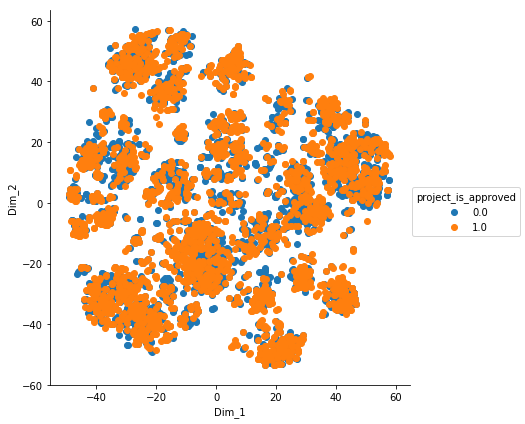

In [117]:
#perplexity=50 & step=1000
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=1000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

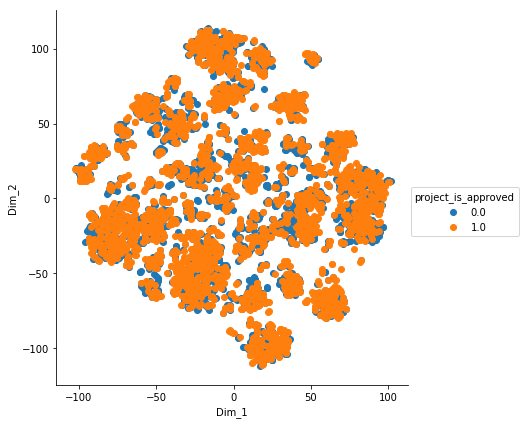

In [118]:
#perplexity=20 & step=2000
model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=2000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

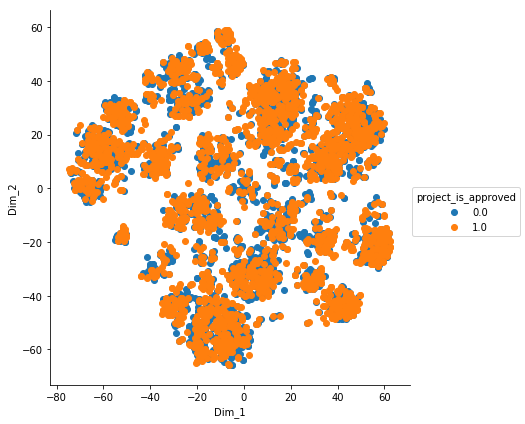

In [191]:
#perplexity=70 & step=3000
model = TSNE(n_components=2, random_state=0, perplexity=70, n_iter=3000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 3.3 TSNE with Avg W2V encoding of project_title feature

#### 3.3.1 Merging features i.e  all catogorical, numerical & Avg W2V vectors.

In [112]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(project_grade_category_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(a.shape)
print(price_standardized.shape)
print(previousprojects_standardized.shape)

(5000, 9)
(5000, 30)
(5000, 51)
(5000, 4)
(5000, 4)
(5000, 50)
(5000, 1)
(5000, 1)


In [113]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix, vstack
import numpy as np

X2 = hstack((categories_one_hot, sub_categories_one_hot,school_state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,a,price_standardized,previousprojects_standardized))
X2.shape

(5000, 150)

#### 3.3.2 T-SNE plots for various values of perplexity & iterations .

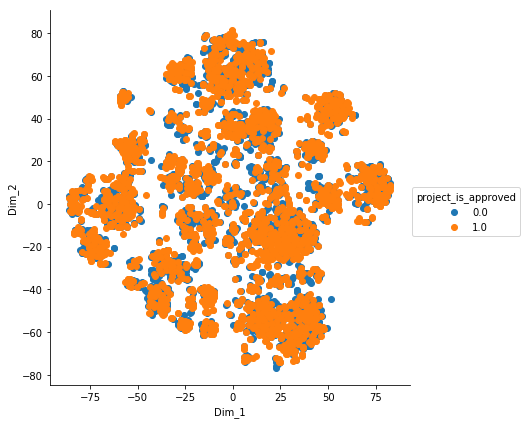

In [179]:
#t-SNE
#perplexity=30 & step=1000
from sklearn.manifold import TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

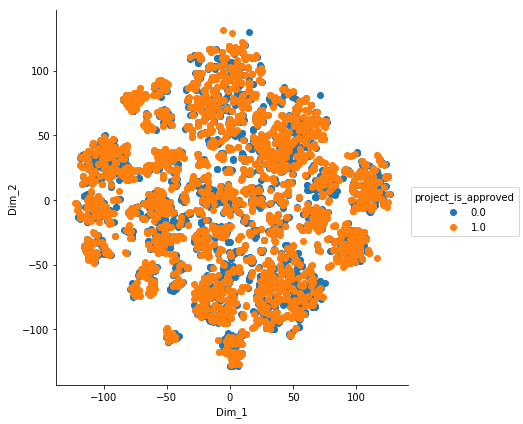

In [180]:
#perplexity=10 & step=1500
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1500)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

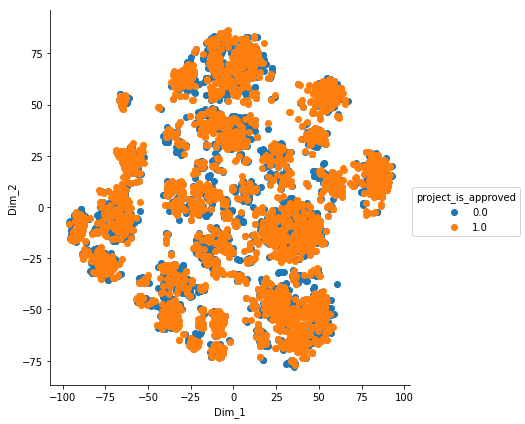

In [181]:
#perplexity=40 & step=2000
model = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=2000)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

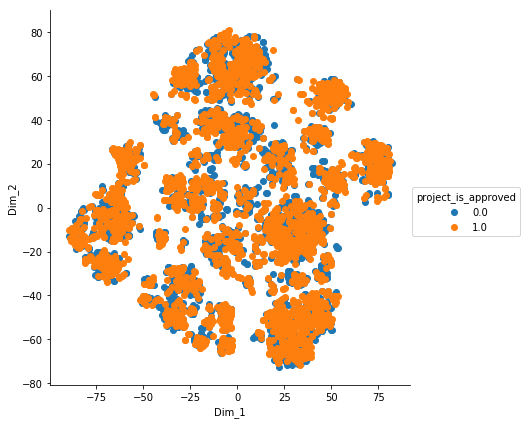

In [182]:
#perplexity=50 & step=2500
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2500)
tsne_data = model.fit_transform(X2.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 3.4 TSNE with TFIDF Weighted W2V encoding of project_title feature

#### 3.4.1 Merging features i.e  all catogorical, numerical & TFIDF W2V vectors.

In [114]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(project_grade_category_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(b.shape)
print(price_standardized.shape)
print(previousprojects_standardized.shape)

(5000, 9)
(5000, 30)
(5000, 51)
(5000, 4)
(5000, 4)
(5000, 50)
(5000, 1)
(5000, 1)


In [115]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix, vstack
import numpy as np

X3 = hstack((categories_one_hot, sub_categories_one_hot,school_state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,b,price_standardized,previousprojects_standardized))
X3.shape

(5000, 150)

#### 3.4.2 T-SNE plots for various values of perplexity & iterations .

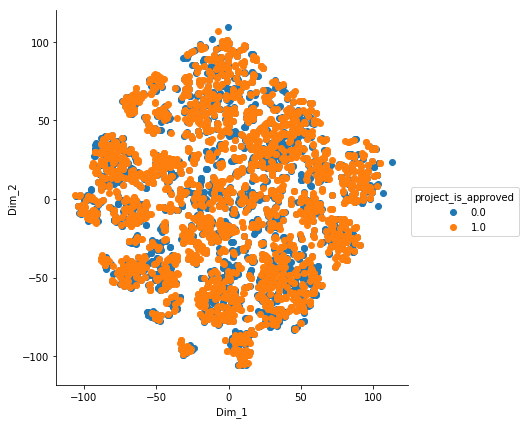

In [187]:
#perplexity=10 & step=1000
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000)
tsne_data = model.fit_transform(X3.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

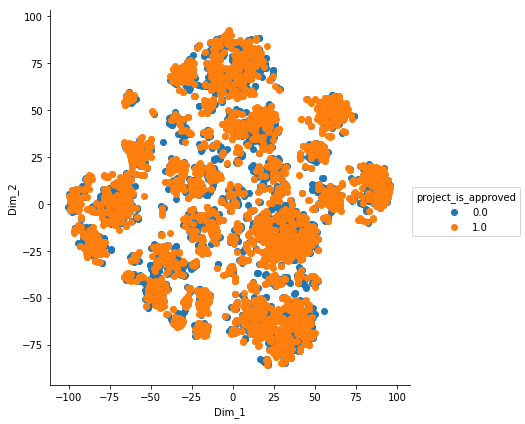

In [188]:
#perplexity=30 & step=1500
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1500)
tsne_data = model.fit_transform(X3.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

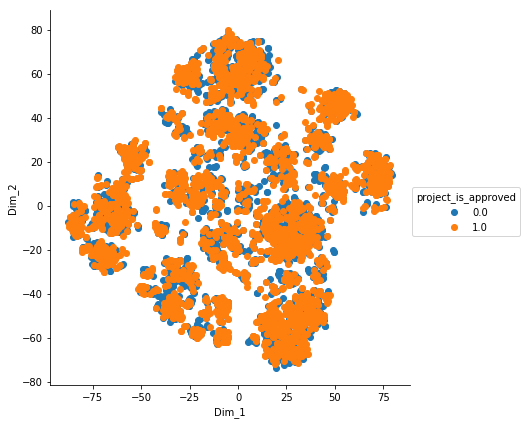

In [189]:
#perplexity=50 & step=2000
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2000)
tsne_data = model.fit_transform(X3.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

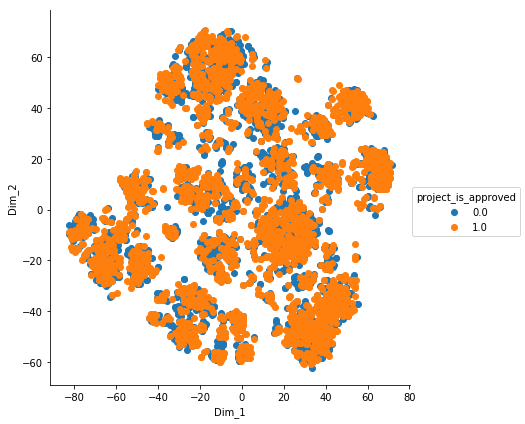

In [190]:
#perplexity=60 & step=2500
model = TSNE(n_components=2, random_state=0, perplexity=60, n_iter=2500)
tsne_data = model.fit_transform(X3.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 3.5 TSNE on all categorical, numerical & text features (project_title)

#### 3.5.1 Final data matrix:

In [116]:
from scipy.sparse import hstack

final = hstack((categories_one_hot, sub_categories_one_hot,school_state_one_hot,project_grade_category_one_hot,teacher_prefix_one_hot,title_bow,title_tfidf,a,b,price_standardized,previousprojects_standardized))
final.shape

(5000, 938)

#### 3.5.2 T-SNE plots for various values of perplexity & iterations.

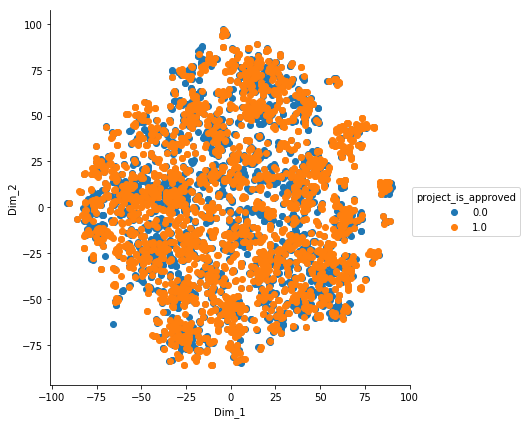

In [194]:
#perplexity=5 & step=1000
model = TSNE(n_components=2, random_state=0, perplexity=5, n_iter=1000)
tsne_data = model.fit_transform(final.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

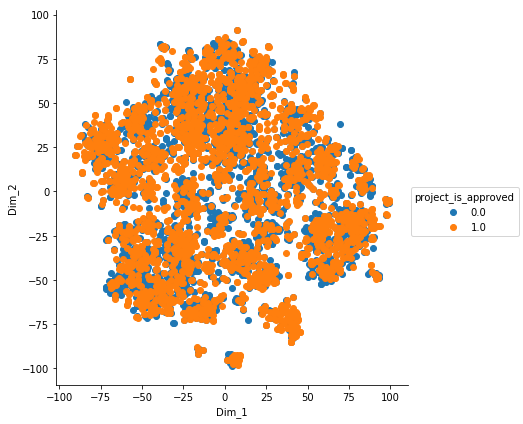

In [195]:
#perplexity=10 & step=1500
model = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1500)
tsne_data = model.fit_transform(final.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

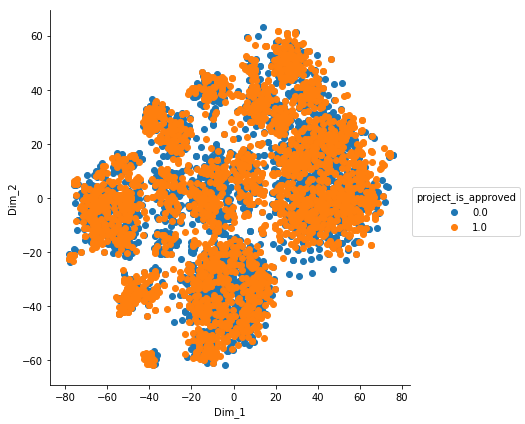

In [196]:
#perplexity=30 & step=2000
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000)
tsne_data = model.fit_transform(final.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

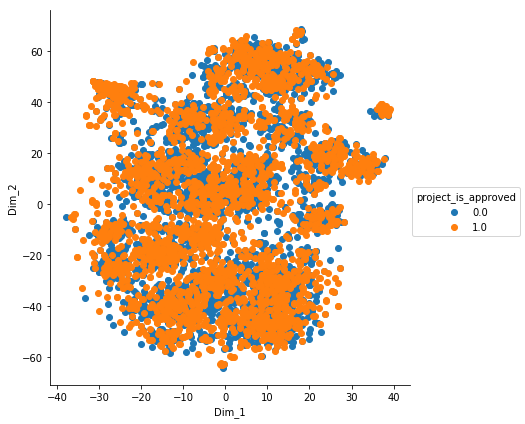

In [197]:
#perplexity=50 & step=2500
model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=2500)
tsne_data = model.fit_transform(final.toarray())
tsne_data = np.vstack((tsne_data.T, data_5K['project_is_approved'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","project_is_approved"))
sns.FacetGrid(tsne_df, hue="project_is_approved", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### 3.6 SUMMARY:

1. T-SNE plots: From all the 5 t-SNE plots with variety in perplexity & iterations, it can be concluded that a clear separation (i.e. by drawing a linear plane) of approved & not approved projects could not be obtained using all the featurizations. Hence a classification model for 5K train examples cannot be built using the visual results of t-SNE. Maybe, applying t-SNE on top of essays and with more train examples can result in clustering of the 2 groups.
2. Key takeaways from the data set in sum:
   - Any project submitted from state Delaware(DE),the likelihood of the project being approved is high
   - Projects submitted by Married women teachers (Mrs) had a higher chance of getting approved
   - Any project related to Warmth Care & Hunger had the highest acceptance rate although the total number of projects in this category was the least.
   - More the words in project titles & essays, greater was the acceptance rate of the projects.
   - More the number of projects submitted previously by teachers, the higher is the chance of that project being approved.